# Measurement noise assessment

In this notebook, we illustrate how to use pyABC with different noise models. For simplicity, we use a simple ODE model of a conversion reaction. For simplicity, we consider a single parameter:

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyabc

init = sp.array([1, 0])

def f(y, t0, theta1, theta2=np.exp(-2)):
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2

theta1_true = np.exp(-2.5)
theta_true = {'theta1': theta1_true}

prior = pyabc.Distribution(
    theta1=pyabc.RV("uniform", 0, 0.2))

measurement_times = sp.arange(10)

/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/utils.py:136: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


We assume that the underlying dynamics of our observations follow the following model:

In [2]:
def model(pars):
    sol = sp.integrate.odeint(
             f, init, measurement_times,
             args=(pars["theta1"],))
    return {'X_2': sol[:,1]}

true_trajectory = model(theta_true)

However, we assume that our measurements are subject to additive Gaussian noise:

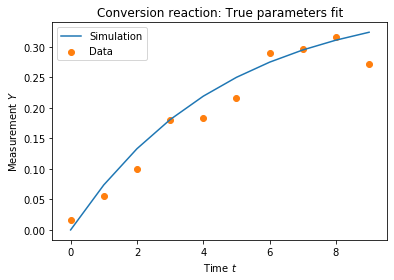

In [3]:
sigma = 0.02

def model_noisy(pars):
    sim = model(pars)
    return {'X_2': sim['X_2'] + sigma * np.random.randn(10)}

measured_data = model_noisy(theta_true)

# plot data
plt.plot(true_trajectory['X_2'], color="C0", label='Simulation')
plt.scatter(measurement_times, measured_data['X_2'],
            color="C1", label='Data')
plt.xlabel('Time $t$')
plt.ylabel('Measurement $Y$')
plt.title('Conversion reaction: True parameters fit')
plt.legend()
plt.show()

In the notebook "Ordinary Differential Equations: Conversion Reaction", this model is used without accounting for a noise model, which is strictly speaking not correct. In this case, we get the following result:

In [4]:
def distance(simulation, data):
    return sp.absolute(data["X_2"] - simulation["X_2"]).sum()

abc = pyabc.ABCSMC(model, prior, distance)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history = abc.run(max_nr_populations=10)

INFO:History:Start <ABCSMC(id=4, start_time=2019-12-06 19:37:30.618767, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 1.0605210378721839
INFO:ABC:t: 0, eps: 1.0605210378721839.
INFO:ABC:Acceptance rate: 100 / 195 = 5.1282e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.6613883222659297.
INFO:ABC:Acceptance rate: 100 / 174 = 5.7471e-01, ESS=9.9492e+01.
INFO:ABC:t: 2, eps: 0.34368499896436494.
INFO:ABC:Acceptance rate: 100 / 223 = 4.4843e-01, ESS=9.8607e+01.
INFO:ABC:t: 3, eps: 0.2181511871426341.
INFO:ABC:Acceptance rate: 100 / 193 = 5.1813e-01, ESS=9.8868e+01.
INFO:ABC:t: 4, eps: 0.21034676540906977.
INFO:ABC:Acceptance rate: 100 / 218 = 4.5872e-01, ESS=9.7232e+01.
INFO:ABC:t: 5, eps: 0.2094912603429865.
INFO:ABC:Acceptance rate: 100 / 196 = 5.1020e-01, ESS=9.9238e+01.
INFO:ABC:t: 6, eps: 0.20910332290805542.
INFO:ABC:Acceptance rate: 100 / 200 = 5.0000e-01, ESS=9.9157e+01.
INFO:ABC:t: 7, eps: 0.20886273807302075.
INFO:ABC:Acceptance rate: 100 / 228

As one can see in the below plot, this converges to a point estimate as $\varepsilon\rightarrow 0$, and does not correctly represent the posterior. In particular, in general this point estimate will not capture the correct parameter value (indicated by the grey line).

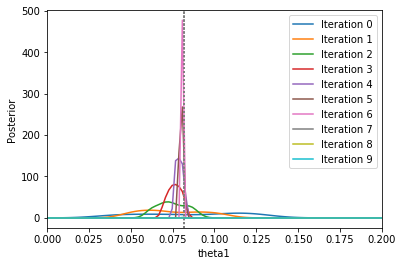

In [5]:
_, ax = plt.subplots()
for t in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x="theta1", t=t, refval=theta_true, refval_color='grey',
        xmin=0, xmax=0.2, numx=100, ax=ax, label=f"Iteration {t}")
ax.legend()

To correctly account for noise, there are essentially two possibilities: Firstly, we can use the noisified model output:

In [6]:
abc = pyabc.ABCSMC(model_noisy, prior, distance)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history_noisy_output = abc.run(max_nr_populations=10)

INFO:History:Start <ABCSMC(id=5, start_time=2019-12-06 19:37:37.947587, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 1.1081544547919933
INFO:ABC:t: 0, eps: 1.1081544547919933.
INFO:ABC:Acceptance rate: 100 / 194 = 5.1546e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.7033839215758176.
INFO:ABC:Acceptance rate: 100 / 171 = 5.8480e-01, ESS=9.8187e+01.
INFO:ABC:t: 2, eps: 0.37901896038316907.
INFO:ABC:Acceptance rate: 100 / 178 = 5.6180e-01, ESS=9.8243e+01.
INFO:ABC:t: 3, eps: 0.28374508910678026.
INFO:ABC:Acceptance rate: 100 / 222 = 4.5045e-01, ESS=9.9397e+01.
INFO:ABC:t: 4, eps: 0.23688257549813885.
INFO:ABC:Acceptance rate: 100 / 361 = 2.7701e-01, ESS=9.6086e+01.
INFO:ABC:t: 5, eps: 0.21136702494374288.
INFO:ABC:Acceptance rate: 100 / 671 = 1.4903e-01, ESS=8.9029e+01.
INFO:ABC:t: 6, eps: 0.18936985421631114.
INFO:ABC:Acceptance rate: 100 / 943 = 1.0604e-01, ESS=8.1464e+01.
INFO:ABC:t: 7, eps: 0.17085461241588576.
INFO:ABC:Acceptance rate: 100 / 2

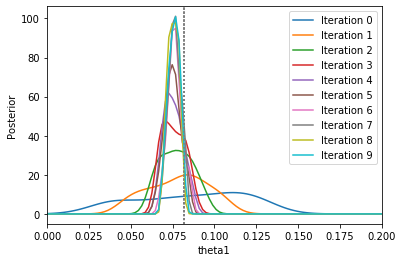

In [7]:
_, ax = plt.subplots()
for t in range(history_noisy_output.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_noisy_output, x="theta1", t=t,
        refval=theta_true, refval_color='grey',
        xmin=0, xmax=0.2, ax=ax, numx=100, label=f"Iteration {t}")
ax.legend()

This curve is much broader and, as one can show, closer to the correct posterior.

Secondly, we can alternatively use the non-noisy model, but adjust the acceptance step:

In [8]:
acceptor = pyabc.StochasticAcceptor()
kernel = pyabc.IndependentNormalKernel(var=sigma**2)
eps = pyabc.Temperature()

abc = pyabc.ABCSMC(model, prior, kernel, eps=eps, acceptor=acceptor)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history_acceptor = abc.run(max_nr_populations=10)

INFO:History:Start <ABCSMC(id=6, start_time=2019-12-06 19:38:04.257965, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 75.81281874088262.
INFO:ABC:Acceptance rate: 100 / 323 = 3.0960e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 5.630145240138284.
INFO:ABC:Acceptance rate: 100 / 389 = 2.5707e-01, ESS=9.8383e+01.
INFO:ABC:t: 2, eps: 1.017220845440427.
INFO:ABC:Acceptance rate: 100 / 315 = 3.1746e-01, ESS=9.8501e+01.
INFO:ABC:t: 3, eps: 1.0.
INFO:ABC:Acceptance rate: 100 / 146 = 6.8493e-01, ESS=7.1772e+01.
INFO:History:Done <ABCSMC(id=6, start_time=2019-12-06 19:38:04.257965, end_time=2019-12-06 19:38:09.105558)>


We use a ``pyabc.StochasticAcceptor`` for the acceptor, replacing the default ``pyabc.UniformAcceptor``, in order to accept when

    \[\pi\]

Here, we use a ``pyabc.IndependentNormalKernel`` to capture the normal noise. Also other noise models are possible, including Laplace or binomial noise.  

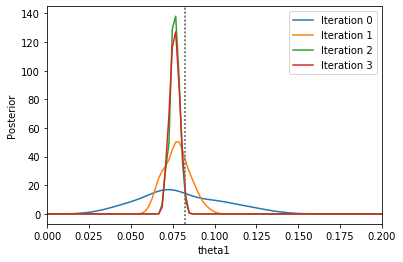

In [9]:
_, ax = plt.subplots()
for t in range(history_acceptor.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history_acceptor, x="theta1", t=t,
        refval=theta_true, refval_color='grey',
        xmin=0, xmax=0.2, ax=ax, numx=100, label=f"Iteration {t}")
ax.legend()

We see that we get essentially the same posterior distribution as with the noisy output, however at a much lower computational cost, as the below plot shows:

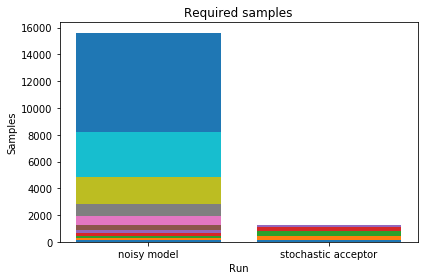

In [10]:
histories = [history_noisy_output, history_acceptor]
labels = ["noisy model", "stochastic acceptor"]

pyabc.visualization.plot_sample_numbers(histories, labels)

Thus, the stochastic acceptor is the proposed method to use in practice. Various noise models and temperature decay schemes are implemented in pyABC. Further details follow.